# Hybrid model with added validation split, early stopping and visuals (loss curve + prediction scatter + rating distribution)

In [2]:
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Dropout, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split

2025-03-25 21:59:24.524550: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [18]:
# feature extraction 

data_dir = "/Users/andresaccone/Downloads/Data/genres_original"
genres = ["blues", "classical", "country", "disco", "hiphop",
          "jazz", "metal", "pop", "reggae", "rock"]

def extract_features(file_path):
    try:
        y, sr = librosa.load(file_path, duration=30)
        tempo = librosa.beat.tempo(y=y, sr=sr)[0]
        rms = np.mean(librosa.feature.rms(y=y))
        spec_centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
        return np.array([tempo, rms, spec_centroid])
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return np.array([0, 0, 0])

song_features, song_ids, song_genres, song_file_paths = [], [], [], []
song_id = 0
max_files_per_genre = 10 # change this if you want more

for genre in genres:
    genre_path = os.path.join(data_dir, genre)
    if not os.path.exists(genre_path):
        print(f"Folder not found: {genre_path}")
        continue
    files = [f for f in os.listdir(genre_path) if f.endswith(".wav")][:max_files_per_genre]
    for file in files:
        path = os.path.join(genre_path, file)
        features = extract_features(path)
        song_features.append(features)
        song_ids.append(song_id)
        song_genres.append(genre)
        song_file_paths.append(path)
        song_id += 1

song_features = np.array(song_features)
num_songs = len(song_features)

/var/folders/m9/s_c7trgx3ngbzvfhxt4zxh5c0000gn/T/ipykernel_41745/2376863140.py:10: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  tempo = librosa.beat.tempo(y=y, sr=sr)[0]


In [20]:
# simluated user rating 

num_users = 100
num_interactions = 2000

users_interactions = np.random.randint(0, num_users, size=(num_interactions, 1))
songs_interactions = np.random.randint(0, num_songs, size=(num_interactions, 1))
ratings = np.random.randint(1, 6, size=(num_interactions, 1)) / 5.0  # 1-5 scaled to 0-1
audio_inputs = np.array([song_features[song_idx] for song_idx in songs_interactions.flatten()])

# train/test split 

train_idx, val_idx = train_test_split(np.arange(len(ratings)), test_size=0.2, random_state=42)
train_inputs = [users_interactions[train_idx], songs_interactions[train_idx], audio_inputs[train_idx]]
val_inputs = [users_interactions[val_idx], songs_interactions[val_idx], audio_inputs[val_idx]]
train_ratings = ratings[train_idx]
val_ratings = ratings[val_idx]

In [22]:
# model architecture 

def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

user_input = Input(shape=(1,), name='user_input')
song_input = Input(shape=(1,), name='song_input')
audio_input = Input(shape=(3,), name='audio_features')

user_embedding = Embedding(input_dim=num_users, output_dim=50)(user_input)
song_embedding = Embedding(input_dim=num_songs, output_dim=50)(song_input)

user_vec = Flatten()(user_embedding)
song_vec = Flatten()(song_embedding)

interaction = Concatenate()([user_vec, song_vec])
collaborative = Dense(64, activation='relu')(interaction)
collaborative = Dropout(0.3)(collaborative)

content = Dense(32, activation='relu')(audio_input)
content = Dropout(0.3)(content)

merged = Concatenate()([collaborative, content])
merged = Dense(64, activation='relu')(merged)
merged = Dropout(0.3)(merged)
merged = Dense(32, activation='relu')(merged)

output = Dense(1, activation='sigmoid')(merged)  # constrain to [0, 1]

model = Model(inputs=[user_input, song_input, audio_input], outputs=output)
model.compile(optimizer='adam', loss='mse', metrics=[rmse, 'mae'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ song_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 1, 50)     │      5,000 │ user_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 1, 50)     │      5,000 │ song_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 50)        │          0 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 50)        │          0 │ embedding_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 100)       │          0 │ flatten_2[0][0],  │
│ (Concatenate)       │                   │            │ flatten_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ audio_features      │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 64)        │      6,464 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 32)        │        128 │ audio_features[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 64)        │          0 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 32)        │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 96)        │          0 │ dropout_3[0][0],  │
│ (Concatenate)       │                   │            │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 64)        │      6,208 │ concatenate_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 64)        │          0 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 32)        │      2,080 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 1)         │         33 │ dense_8[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 24,913 (97.32 KB)

 Trainable params: 24,913 (97.32 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
# model training

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(train_inputs, train_ratings, epochs=10, batch_size=32,
                    validation_data=(val_inputs, val_ratings), callbacks=[early_stop])

Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.2589 - mae: 0.4212 - rmse: 0.5068 - val_loss: 0.2608 - val_mae: 0.4190 - val_rmse: 0.5083
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2318 - mae: 0.3907 - rmse: 0.4791 - val_loss: 0.2608 - val_mae: 0.4190 - val_rmse: 0.5083
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2353 - mae: 0.3919 - rmse: 0.4834 - val_loss: 0.2608 - val_mae: 0.4190 - val_rmse: 0.5083
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.2352 - mae: 0.3948 - rmse: 0.4836 - val_loss: 0.2608 - val_mae: 0.4190 - val_rmse: 0.5083


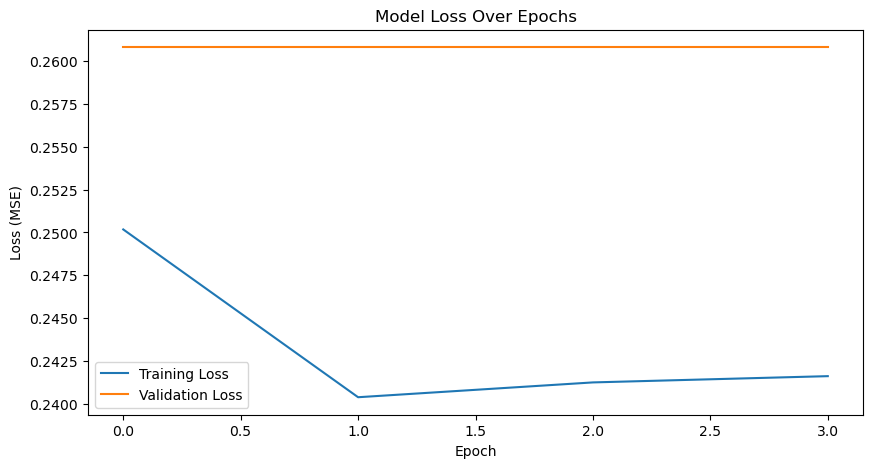

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


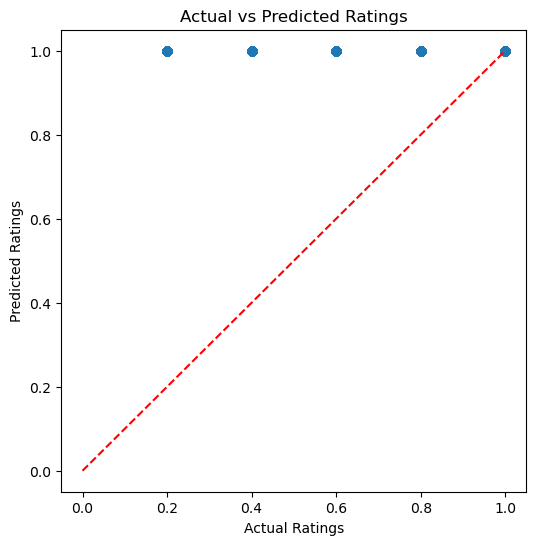

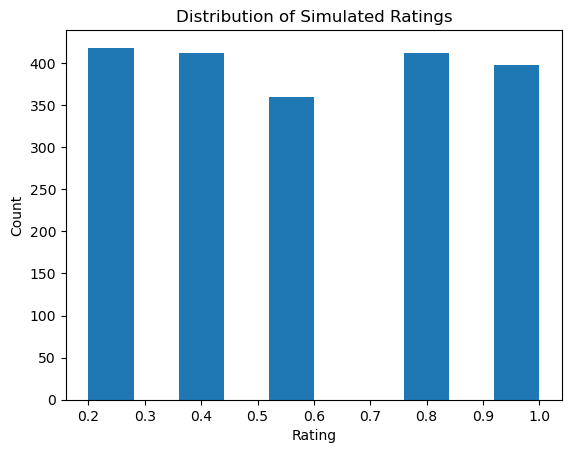

In [42]:
# visualizations

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

predictions = model.predict([users_interactions, songs_interactions, audio_inputs])
plt.figure(figsize=(6, 6))
plt.scatter(ratings, predictions, alpha=0.5)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.title('Actual vs Predicted Ratings')
plt.show()

plt.hist(ratings, bins=10)
plt.title("Distribution of Simulated Ratings")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()